# Regression with Pycaret

Kaggle project: House Prices: Advanced Regression Techniques

https://www.kaggle.com/c/house-prices-advanced-regression-techniques


This is the ML part of the project. The major steps are the following:

1. Initialize the setup
2. Quickly compare all models
3. Create 5 models: rf, svm, xgb, lgbm, catboost
4. Blend and stack models
5. Predict on hold-out and test data

The output data will be saved to csv file for submission on kaggle.

In [ ]:
!pip install pycaret

In [2]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode activated.


In [18]:
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport


from pycaret.regression import *

In [15]:
print(pandas_profiling.__version__)

2.8.0


## Load data



In [7]:
train=pd.read_csv('train_dp.csv')
test=pd.read_csv('test_dp.csv')

In [19]:
train.profile_report()

In [21]:
train.dtypes.value_counts()

int64     35
object    28
dtype: int64

## Initialize the setup

In [22]:
reg = setup(data = train, target = 'SalePrice', session_id=0,
            categorical_imputation = 'mode', 
            bin_numeric_features = None,  # test yearbuilt 
            numeric_imputation = 'mean', 
            ignore_features = ['Id'], 
            normalize = True, transformation = True, transformation_method = 'yeo-johnson', 
            transform_target = True,  transform_target_method = 'box-cox',
            handle_unknown_categorical = True, unknown_categorical_method = 'most_frequent',
            pca = False, pca_method = 'linear',  pca_components = 0.99, # test
            ignore_low_variance = False,    # test
            combine_rare_levels = True, rare_level_threshold = 0.05,
            remove_outliers = False, outliers_threshold = 0.05,  # test 
            remove_perfect_collinearity = True,
            remove_multicollinearity = True, multicollinearity_threshold = 0.95,
            silent = False 
            )    

 
Setup Succesfully Completed.


,Description,Value
0,session_id,0
1,Transform Target,True
2,Transform Target Method,box-cox
3,Original Data,"(1460, 63)"
4,Missing Values,True
5,Numeric Features,18
6,Categorical Features,44
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


## Compare all models
 



In [25]:
model_list = ['lr','dt','rf','svm','knn','br','ada','gbr','xgboost','lightgbm','catboost']

compare_models(whitelist = model_list, fold = 5,  round = 4,  sort = 'RMSLE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Bayesian Ridge,15165.3731,777884793.1749,26828.2377,0.8735,0.1259,0.0874,0.0938
1,CatBoost Regressor,15830.0398,816155889.2568,27776.2738,0.8671,0.1315,0.0910,4.8938
2,Support Vector Machine,15909.1377,830475223.2015,27857.3895,0.8695,0.1383,0.0935,0.2302
3,Extreme Gradient Boosting,17656.5656,912546801.1611,29328.6079,0.8521,0.1422,0.1024,0.4200
4,Gradient Boosting Regressor,17583.9422,1018837073.3524,30798.1072,0.8375,0.1425,0.1003,0.5765
5,Light Gradient Boosting Machine,18102.2812,920113818.1352,29809.4925,0.8495,0.1494,0.1064,0.2084
6,Random Forest,18783.5371,1009781027.1953,31218.4912,0.8365,0.1540,0.1093,1.3272
7,K Neighbors Regressor,22626.6733,1450629220.0164,37311.3430,0.7671,0.1847,0.1312,0.0191
8,AdaBoost Regressor,26294.4056,1689680083.9144,40665.4074,0.7253,0.1929,0.1446,0.3729
9,Decision Tree,29211.0611,2195587231.3761,46306.3979,0.6346,0.2262,0.1668,0.0332


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

##Create a model
RF, SVM, XGB, LGBM, CatB

In [26]:
rf = create_model('rf', fold = 10, round = 4, n_estimator=10)
print(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15947.9059,673804767.4046,25957.7497,0.8541,0.1272,0.0896
1,22347.6607,1994691437.5260,44661.9686,0.7266,0.2138,0.1502
2,19711.1030,976581801.6536,31250.3088,0.8394,0.1469,0.1066
3,20387.6039,769580067.3400,27741.3062,0.8950,0.1732,0.1274
4,19165.5539,915869922.1352,30263.3429,0.8486,0.1890,0.1273
5,21716.8797,1935333953.5518,43992.4306,0.7961,0.1419,0.0945
6,17506.4050,565743110.0063,23785.3549,0.8756,0.1315,0.1000
7,17821.9738,812073067.4709,28496.8958,0.8575,0.1365,0.0985
8,15351.4775,555466371.5016,23568.3341,0.8950,0.1174,0.0886
9,13863.5581,433750352.2454,20826.6741,0.8835,0.1201,0.0872


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)


In [28]:
tuned_rf = tune_model(rf)
print(tuned_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15605.3579,648726350.7231,25470.1070,0.8596,0.1235,0.0879
1,22021.6538,1813114636.3715,42580.6838,0.7515,0.2072,0.1473
2,19933.1843,1030529359.2717,32101.8591,0.8306,0.1458,0.1066
3,19037.5851,723689548.5169,26901.4786,0.9013,0.1639,0.1179
4,19541.0770,1032012374.6992,32124.9494,0.8294,0.1953,0.1305
5,23483.9409,2043842992.3604,45208.8818,0.7846,0.1512,0.1022
6,18008.3868,637281484.1186,25244.4347,0.8598,0.1360,0.1023
7,17538.2098,841513758.2417,29008.8565,0.8523,0.1315,0.0975
8,15230.1081,541832327.7214,23277.2921,0.8976,0.1193,0.0893
9,14751.5296,483872221.4286,21997.0957,0.8700,0.1256,0.0919


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)


In [29]:
svm = create_model('svm')
tuned_svm = tune_model(svm)
print(tuned_svm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,27020.1825,1610744958.7993,40134.0872,0.6513,0.2018,0.1447
1,32434.8143,2383184568.7534,48817.8714,0.6734,0.2577,0.1967
2,32095.0929,2145567450.6107,46320.2704,0.6472,0.2163,0.1607
3,34994.3177,2174430483.3579,46630.7890,0.7034,0.2366,0.1817
4,32119.9021,2220097555.0721,47117.9112,0.6330,0.2453,0.1835
5,43555.2950,5688621497.5850,75422.9507,0.4005,0.2760,0.1806
6,27548.9936,1275149418.3639,35709.2344,0.7195,0.2024,0.1521
7,31599.4763,2513657046.1953,50136.3845,0.5589,0.2243,0.1639
8,24126.9888,1238716548.0709,35195.4052,0.7659,0.1789,0.1339
9,24976.8524,1127213876.1228,33574.0060,0.6971,0.1932,0.1448


SVR(C=4.438, cache_size=200, coef0=0.0, degree=3, epsilon=1.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=False, tol=0.001, verbose=False)


In [30]:
lgbm = create_model('lightgbm')
tuned_lgbm = tune_model(lgbm)
print(tuned_lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15960.7993,567409743.3897,23820.3640,0.8772,0.1260,0.0918
1,22380.4112,1846798771.2852,42974.3967,0.7469,0.2177,0.1517
2,19096.1713,926828443.9338,30443.8572,0.8476,0.1406,0.1038
3,19642.5904,711503003.6244,26674.0136,0.9029,0.1741,0.1247
4,19274.2815,911149763.8576,30185.2574,0.8494,0.1880,0.1273
5,23149.9571,2081789592.3897,45626.6325,0.7806,0.1456,0.1007
6,14525.6353,401529906.0375,20038.2111,0.9117,0.1091,0.0832
7,17602.3586,794764913.5246,28191.5752,0.8605,0.1384,0.0988
8,15988.1918,490519155.1625,22147.6670,0.9073,0.1315,0.0986
9,13550.1506,405957373.8896,20148.3839,0.8909,0.1125,0.0820


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=50,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.2,
              n_estimators=150, n_jobs=-1, num_leaves=20, objective=None,
              random_state=0, reg_alpha=0.9, reg_lambda=0.9, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [31]:
xgb = create_model('xgboost')
tuned_xgb = tune_model(xgb)
print(tuned_xgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,13871.0624,382805639.3138,19565.4195,0.9171,0.1111,0.0811
1,23127.6999,2568197021.9511,50677.3818,0.6480,0.2102,0.1486
2,17743.5161,856531237.4239,29266.5549,0.8592,0.1282,0.0920
3,19564.8844,776459823.2396,27865.0287,0.8941,0.1596,0.1129
4,16962.7603,787948165.8524,28070.4144,0.8697,0.1650,0.1079
5,23731.4904,2074424937.4499,45545.8553,0.7814,0.1577,0.1077
6,15001.9764,485008019.0102,22022.8976,0.8933,0.1137,0.0844
7,16594.9723,640934776.6960,25316.6897,0.8875,0.1264,0.0950
8,13754.1824,410360013.8574,20257.3447,0.9224,0.1073,0.0844
9,13400.5874,475265347.0880,21800.5813,0.8723,0.1127,0.0816


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=60, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.3, verbosity=0)


In [32]:
cat = create_model('catboost')
tuned_cat = tune_model(cat)
print(tuned_cat)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,12248.4549,349807277.3037,18703.1355,0.9243,0.0991,0.0692
1,20426.9882,2482013505.6670,49819.8104,0.6598,0.1923,0.1295
2,17417.8705,830946453.9928,28826.1419,0.8634,0.1365,0.0972
3,15497.6451,458903655.5166,21422.0367,0.9374,0.1416,0.0954
4,15909.8353,722981694.1714,26888.3189,0.8805,0.1577,0.1012
5,18132.6460,1319751990.6305,36328.3910,0.8609,0.1181,0.0812
6,13272.1861,346755503.1110,18621.3722,0.9237,0.1042,0.0761
7,14929.9619,631712246.3937,25133.8864,0.8891,0.1119,0.0828
8,11676.1208,297162473.0498,17238.4011,0.9438,0.0931,0.0692
9,12900.7192,374602249.1422,19354.6441,0.8993,0.1051,0.0788


## Ensenble a model

## Blending

In [51]:
ensemble_list = [tuned_rf, tuned_svm, tuned_lgbm, tuned_xgb, tuned_cat]
blended = blend_models(estimator_list = ensemble_list )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,14896.6289,533455946.1143,23096.6653,0.8845,0.1134,0.0823
1,21395.2676,1776805059.8397,42152.1655,0.7565,0.2007,0.1391
2,18485.0182,920451498.0524,30338.9436,0.8487,0.1353,0.0969
3,19200.1942,706878963.5460,26587.1955,0.9036,0.1575,0.1131
4,18367.1482,958868531.2059,30965.6024,0.8415,0.1773,0.1147
5,24195.8691,2359479336.7205,48574.4721,0.7514,0.1546,0.1026
6,14790.3820,447451666.6742,21153.0534,0.9016,0.1131,0.0841
7,16889.5102,882922451.6303,29714.0110,0.8451,0.1268,0.0901
8,12970.0687,441893726.1028,21021.2684,0.9165,0.1010,0.0725
9,12962.3529,409969652.6845,20247.7073,0.8898,0.1090,0.0793


###Stacking

In [37]:
stack = stack_models([tuned_rf, tuned_svm, tuned_lgbm, tuned_xgb], meta_model=tuned_cat )  # By default restack =  True

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,13752.4161,406629952.2673,20165.0676,0.9120,0.1105,0.0795
1,21545.0552,2319836821.3990,48164.6844,0.6821,0.1947,0.1352
2,16569.1459,804207852.0569,28358.5587,0.8678,0.1344,0.0929
3,17183.6093,537855987.6267,23191.7224,0.9266,0.1596,0.1057
4,16354.7730,778219327.4769,27896.5827,0.8713,0.1733,0.1097
5,21365.2664,1444422209.0834,38005.5550,0.8478,0.1299,0.0960
6,14229.9728,394720878.8711,19867.5836,0.9132,0.1137,0.0831
7,16149.9100,766216095.6065,27680.6087,0.8655,0.1222,0.0883
8,14635.8963,441963753.6614,21022.9340,0.9165,0.1046,0.0834
9,13683.5244,435795247.1090,20875.7095,0.8829,0.1096,0.0825


## Model performance

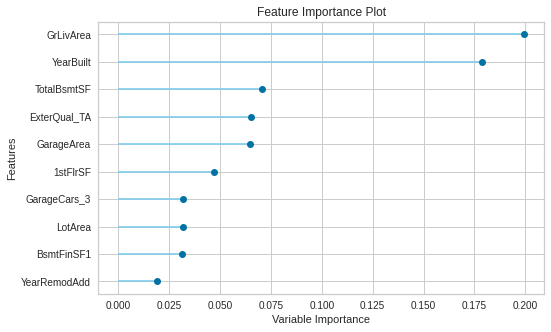

In [59]:
plot_model(tuned_rf, plot='feature')

In [44]:
evaluate_model(tuned_xgb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Predict on test / hold-out Sample

In [45]:
predict_model(tuned_rf);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,18320.0868,1.051261e+09,32423.1484,0.8449,0.1385,0 0.097471 dtype: float64


In [46]:
predict_model(tuned_xgb);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting Regressor,17246.9066,1.042920e+09,32294.2652,0.8461,0.1318,0 0.091818 dtype: float64


In [47]:
predict_model(tuned_lgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,17869.4876,1.068421e+09,32686.707,0.8423,0.1378,0 0.095688 dtype: float64


In [49]:
predict_model(tuned_cat);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,15850.9431,8.553666e+08,29246.6503,0.8738,0.1241,0 0.085969 dtype: float64


In [50]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,17460.4463,1.061287e+09,32577.3944,0.8434,0.1299,0 0.08947 dtype: float64


In [60]:
predict_model(stack);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,16590.5754,8.181985e+08,28604.1694,0.8793,0.1276,0 0.089767 dtype: float64


## Finalize Model

In [61]:
final_stack = finalize_model(stack)
print(final_stack)

/usr/local/lib/python3.6/dist-packages/pycaret/regression.py:6746: UserWarning:

This function will adopt to Stackingclassifer() from sklearn in future release of PyCaret 2.x.



[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False), SVR(C=4.438, cache_size=200, coef0=0.0, degree=3, epsilon=1.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=False, tol=0.001, verbose=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=50,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.2,
              n_estimators=150, n_jobs=-1, num_leaves=20, objective=None,
              random_state=0, reg_alpha=0.9, reg_la

##Predict on test data

In [62]:
predictions = predict_model(final_stack, data=test)
predictions.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Label
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,128128.4719
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,166359.0761
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,188267.0711
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,602.0,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,2.0,470.0,Y,360,36,0,0,0,0,0,6,2010,WD,Normal,203490.1586
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,Gd,TA,PConc,263.0,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,2.0,506.0,Y,0,82,0,0,144,0,0,1,2010,WD,Normal,198917.5128


## Output data

In [65]:
submission = predictions[['Id','Label']]
submission.rename(columns={'Label':'SalePrice'}, inplace=True)
submission.head()

,Id,SalePrice
0,1461,128128.4719
1,1462,166359.0761
2,1463,188267.0711
3,1464,203490.1586
4,1465,198917.5128


In [66]:
submission.to_csv('submission_pycaret_1.csv',index=False)

## Save the model

In [ ]:
#save_model(final_stack,'Final stack Model 20200801_01')

## Reference

https://pycaret.org/regression/